In [ ]:
from google.colab import drive

drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2024-05-08 08:44:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-05-08 08:44:42--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.24MB/s    in 28s     

2024-05-08 08:45:11 (8.36 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.models import load_model
from keras.callbacks import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [ ]:

train_datagen = ImageDataGenerator(
    rescale= 1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb',
                                                    batch_size=256, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [ ]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=True, seed=42)


Found 10000 validated image filenames belonging to 200 classes.


In [ ]:
x_val_all = []
y_val_all = []

# Loop over the generator until all validation data is exhausted
for i in range(int(0.1*len(validation_generator))):
    x_batch, y_batch = next(validation_generator)
    x_val_all.append(x_batch)
    y_val_all.append(y_batch)

# Concatenate all batches to get the entire validation set
x_val = np.concatenate(x_val_all)
y_val = np.concatenate(y_val_all)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(1024, 64, 64, 3)
(1024, 200)


In [ ]:
x_train_all = []
y_train_all = []

# Determine the number of steps (batches) required to cover the entire training set
num_steps = len(train_generator)

# Loop over the generator until all training data is exhausted
for i in range(int(num_steps)):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate all batches to get the entire training set
x_train = np.concatenate(x_train_all)
y_train = np.concatenate(y_train_all)


In [ ]:
print(x_train.shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 200)


In [ ]:
# Keras, dataset, and VGG19 imports
import keras
from keras.applications import VGG19

In [ ]:
# Loading VGG19 with imagenet weights
from keras.layers import Input

vgg19_model = VGG19(include_top = True, weights='imagenet')
vgg19_model.summary()

574710816/574710816 [==============================] - 7s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# define new empty model
model = Sequential()

# add all layers except output from VGG19 to new model
for layer in vgg19_model.layers[:-1]:
  model.add(layer)

# freeze all weights
for layer in model.layers:
  layer.trainable = False

# add dropout layer and new output layer
model.add(Dropout(0.5))
model.add(Dense(200, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
import numpy as np
import cv2

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [31]:
# returns batch_size random samples from either training set or validation set
# resizes each image to (224, 244, 3), the native input size for VGG19
def getBatch(batch_size, train_or_val='train'):
  x_batch = []
  y_batch = []
  if train_or_val == 'train':
    idx = np.random.randint(0, len(x_train), (batch_size))

    for i in idx:
      img = cv2.resize(x_train[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      #img = x_train[i]
      x_batch.append(img)
      y_batch.append(y_train[i])
  elif train_or_val == 'val':
    idx = np.random.randint(0, len(x_val), (batch_size))

    for i in idx:
      img = cv2.resize(x_val[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      #img=x_val[i]
      x_batch.append(img)
      y_batch.append(y_val[i])
  else:
    print("error, please specify train or val")

  x_batch = np.array(x_batch)
  y_batch = np.array(y_batch)
  return x_batch, y_batch


In [32]:
EPOCHS = 7
BATCH_SIZE = 128
VAL_SIZE = 500
STEPS = 50


for e in range(EPOCHS):
  train_loss = 0
  train_acc = 0

  for s in range(STEPS):
    x_batch, y_batch = getBatch(BATCH_SIZE, "train")
    out = model.train_on_batch(x_batch, y_batch)
    train_loss += out[0]
    train_acc += out[1]

  print(f"Epoch: {e}\nTraining Loss = {train_loss / STEPS}\tTraining Acc = {train_acc / STEPS}")

  x_v, y_v = getBatch(VAL_SIZE, "val")
  eval = model.evaluate(x_v, y_v)
  print(f"Validation loss: {eval[0]}\tValidation Acc: {eval[1]}\n")




Epoch: 0
Training Loss = 4.945769271850586	Training Acc = 0.058125
16/16 [==============================] - 11s 693ms/step - loss: 4.7505 - categorical_accuracy: 0.0700
Validation loss: 4.7504987716674805	Validation Acc: 0.07000000029802322

Epoch: 1
Training Loss = 4.8804563045501705	Training Acc = 0.061875
16/16 [==============================] - 11s 698ms/step - loss: 4.6888 - categorical_accuracy: 0.0920
Validation loss: 4.688815593719482	Validation Acc: 0.09200000017881393

Epoch: 2
Training Loss = 4.9020954132080075	Training Acc = 0.05796875
16/16 [==============================] - 11s 688ms/step - loss: 4.5110 - categorical_accuracy: 0.0820
Validation loss: 4.511025905609131	Validation Acc: 0.0820000022649765

Epoch: 3
Training Loss = 4.873461894989013	Training Acc = 0.05671875
16/16 [==============================] - 11s 697ms/step - loss: 4.6612 - categorical_accuracy: 0.0720
Validation loss: 4.661202907562256	Validation Acc: 0.07199999690055847

Epoch: 4
Training Loss = 4.816

In [30]:
print(x_train.shape)

(100000, 32, 32, 3)


In [33]:
x_v, y_v = getBatch(VAL_SIZE, "val")
eval1 = model.evaluate(x_v, y_v)
print(f"Validation loss: {eval1[0]}\tValidation Acc: {eval1[1]}\n")

16/16 [==============================] - 12s 717ms/step - loss: 4.6379 - categorical_accuracy: 0.1060
Validation loss: 4.637861251831055	Validation Acc: 0.10599999874830246



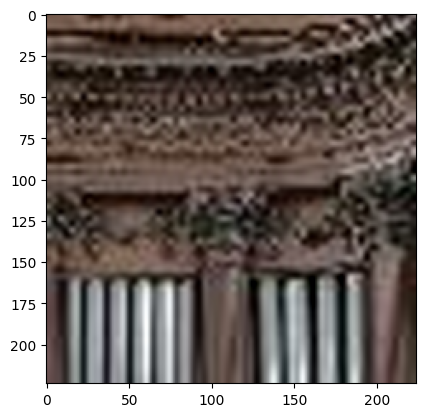

1/1 [==============================] - 0s 129ms/step


pred: 129
acct: 126


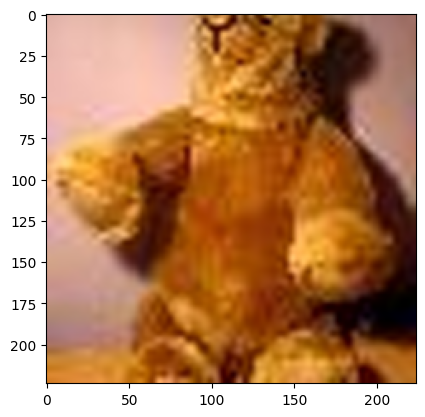

1/1 [==============================] - 0s 127ms/step


pred: 180
acct: 161


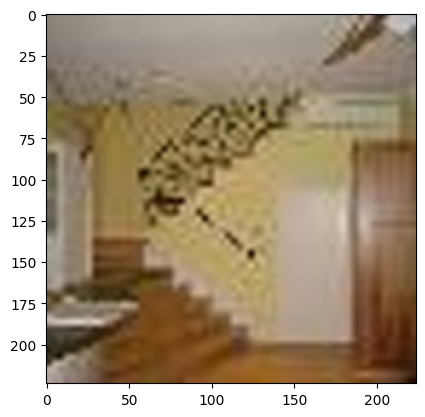

1/1 [==============================] - 0s 125ms/step


pred: 120
acct: 64


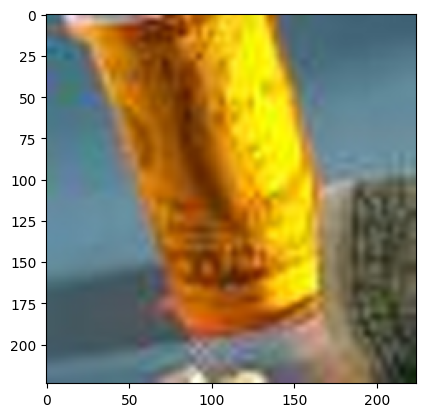

1/1 [==============================] - 0s 142ms/step


pred: 130
acct: 130


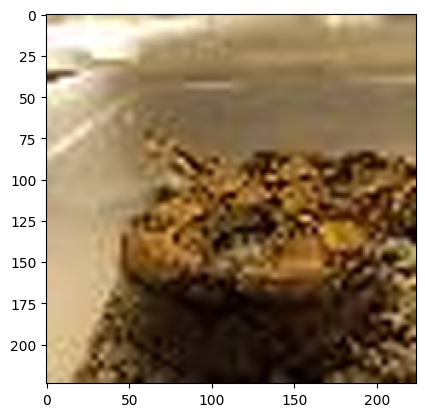

1/1 [==============================] - 0s 143ms/step


pred: 195
acct: 5


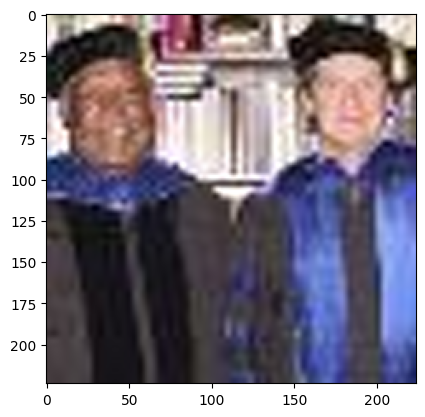

1/1 [==============================] - 0s 128ms/step


pred: 120
acct: 60


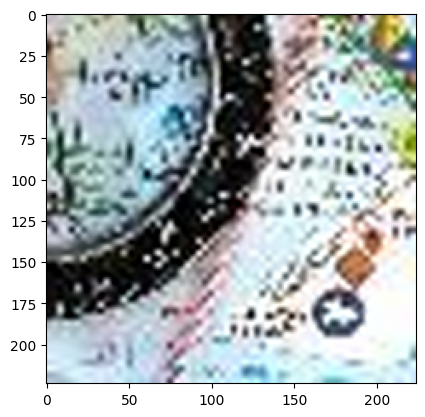

1/1 [==============================] - 0s 151ms/step


pred: 147
acct: 117


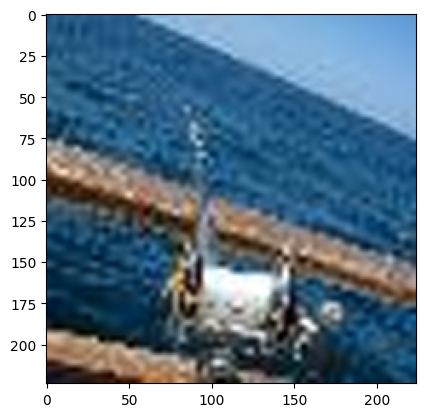

1/1 [==============================] - 0s 144ms/step


pred: 170
acct: 139


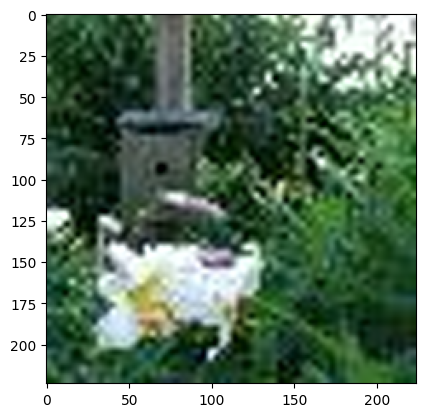

1/1 [==============================] - 0s 125ms/step


pred: 55
acct: 76


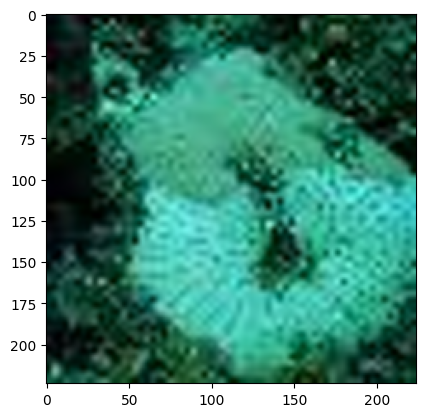

1/1 [==============================] - 0s 142ms/step
pred: 58
acct: 14


In [34]:
class_names = [
    "goldfish",
    "European fire salamander",
    "bullfrog",
    "toad",
    "American alligator",
    "scorpion",
    "trilobite",
    "scorpion",
    "black widow",
    "tarantula",
    "centipede",
    "goose",
    "cock",
    "jellyfish",
    "brain coral",
    "sea slug",
    "slug",
    "sea anemone",
    "American lobster",
    "crayfish",
    "spoonbill",
    "flamingo",
    "little blue heron",
    "bustard",
    "ruddy turnstone",
    "red-backed sandpiper",
    "redshank",
    "dowitcher",
    "oystercatcher",
    "pelican",
    "egret",
    "albatross",
    "grey whale",
    "killer whale",
    "dugong",
    "sea lion",
    "Chihuahua",
    "Japanese spaniel",
    "Maltese dog",
    "Pekinese",
    "Shih-Tzu",
    "Blenheim spaniel",
    "papillon",
    "toy terrier",
    "Rhodesian ridgeback",
    "Afghan hound",
    "basset",
    "beagle",
    "bloodhound",
    "bluetick",
    "black-and-tan coonhound",
    "Walker hound",
    "English foxhound",
    "redbone",
    "borzoi",
    "Irish wolfhound",
    "Italian greyhound",
    "whippet",
    "Ibizan hound",
    "Norwegian elkhound",
    "otterhound",
    "Saluki",
    "Scottish deerhound",
    "Weimaraner",
    "Staffordshire bullterrier",
    "American Staffordshire terrier",
    "Bedlington terrier",
    "Border terrier",
    "Kerry blue terrier",
    "Irish terrier",
    "Norfolk terrier",
    "Norwich terrier",
    "Yorkshire terrier",
    "wire-haired fox terrier",
    "Lakeland terrier",
    "Sealyham terrier",
    "Airedale",
    "cairn",
    "Australian terrier",
    "Dandie Dinmont",
    "Boston bull",
    "miniature schnauzer",
    "giant schnauzer",
    "standard schnauzer",
    "Scotch terrier",
    "Tibetan terrier",
    "Silky terrier",
    "soft-coated wheaten terrier",
    "West Highland white terrier",
    "Lhasa",
    "flat-coated retriever",
    "curly-coated retriever",
    "golden retriever",
    "Labrador retriever",
    "Chesapeake Bay retriever",
    "English setter",
    "Irish setter",
    "Gordon setter",
    "Brittany spaniel",
    "Clumber",
    "English springer",
    "Welsh springer spaniel",
    "cocker spaniel",
    "Sussex spaniel",
    "Irish water spaniel",
    "Kuvasz",
    "Pembroke",
    "Welsh corgi",
    "Cardigan",
    "Old English sheepdog",
    "Shetland sheepdog",
    "collie",
    "Border collie",
    "Bouvier des Flandres",
    "Rottweiler",
    "black-and-tan coonhound",
    "Saint Bernard",
    "Newfoundland",
    "Great Pyrenees",
    "Samoyed",
    "Pomeranian",
    "Eskimo dog",
    "malamute",
    "Siberian husky",
    "dalmatian",
    "Affenpinscher",
    "basenji",
    "pug",
    "Mexican hairless",
    "Rottweiler",
    "French bulldog",
    "Great Dane",
    "Newfoundland",
    "Eskimo dog",
    "miniature poodle",
    "standard poodle",
    "toy poodle",
    "Mexican hairless",
    "timber wolf",
    "white wolf",
    "red wolf",
    "coyote",
    "dingo",
    "dhole",
    "African hunting dog",
    "hyena",
    "red fox",
    "kit fox",
    "Arctic fox",
    "grey fox",
    "tabby",
    "tiger cat",
    "Persian cat",
    "Siamese cat",
    "Egyptian cat",
    "cougar",
    "lynx",
    "leopard",
    "snow leopard",
    "jaguar",
    "lion",
    "tiger",
    "cheetah",
    "brown bear",
    "American black bear",
    "ice bear",
    "sloth bear",
    "mongoose",
    "meerkat",
    "tiger beetle",
    "ladybug",
    "ground beetle",
    "long-horned beetle",
    "leaf beetle",
    "dung beetle",
    "rhinoceros beetle",
    "weevil",
    "fly",
    "bee",
    "ant",
    "grasshopper",
    "cricket",
    "walking stick",
    "cockroach",
    "mantis",
    "cicada",
    "leafhopper",
    "lacewing",
    "dragonfly",
    "damselfly",
    "admiral",
    "ringlet",
    "monarch",
    "cabbage butterfly",
    "sulphur butterfly",
    "lycaenid",
    "starfish",
    "sea urchin",
    "sea cucumber",
    "wood rabbit",
    "hare",
    "Angora",
    "hamster",
    "porcupine",
    "fox squirrel",
    "marmot",
    "beaver",
    "guinea pig",
    "sorrel",
    "zebra",
    "hog",
    "wild boar",
    "warthog",
    "hippopotamus",
    "ox",
    "water buffalo",
    "bison",
    "ram",
    "bighorn",
    "ibex",
    "hartebeest",
    "impala",
    "gazelle",
    "Arabian camel",
    "llama",
    "weasel",
    "mink",
    "polecat",
    "black-footed ferret",
    "otter",
    "skunk",
    "badger",
    "armadillo",
    "three-toed sloth",
    "orangutan",
    "gorilla",
    "chimpanzee",
    "gibbon",
    "siamang",
    "guenon",
    "patas",
    "baboon",
    "macaque",
    "langur",
    "colobus",
    "proboscis monkey",
    "marmoset",
    "capuchin",
    "howler monkey",
    "titi",
    "spider monkey",
    "squirrel monkey",
    "Madagascar cat",
    "indri",
    "Indian elephant",
    "African elephant",
    "lesser panda",
    "giant panda",
    "barracouta",
    "eel",
    "coho",
    "rock beauty",
    "anemone fish",
    "sturgeon",
    "gar",
    "lionfish",
    "puffer",
    "abacus",
    "abaya",
    "academic gown",
    "accordion",
    "acoustic guitar",
    "aircraft carrier",
    "airliner",
    "airship",
    "altar",
    "ambulance",
    "amphibian",
    "analog clock",
    "apiary",
    "apron",
    "ashcan",
    "assault rifle",
    "backpack",
    "bakery",
    "balance beam",
    "balloon",
    "ballpoint",
    "Band Aid",
    "banjo",
    "bannister",
    "barbell",
    "barber chair",
    "barbershop",
    "barn",
    "barometer",
    "barrel",
    "barrow",
    "baseball",
    "basketball",
    "bassinet",
    "bassoon",
    "bathing cap",
    "bath towel",
    "bathtub",
    "beach wagon",
    "beacon",
    "beaker",
    "bearskin",
    "beer bottle",
    "beer glass",
    "bell cote",
    "bib",
    "bicycle-built-for-two",
    "bikini",
    "binder",
    "binoculars",
    "birdhouse",
    "boathouse",
    "bobsled",
    "bolo tie",
    "bonnet",
    "bookcase",
    "bookshop",
    "bottlecap",
    "bow",
    "bow tie",
    "brass",
    "brassiere",
    "breakwater",
    "breastplate",
    "broom",
    "bucket",
    "buckle",
    "bulletproof vest",
    "bullet train",
    "butcher shop",
    "cab",
    "caldron",
    "candle",
    "cannon",
    "canoe",
    "can opener",
    "cardigan",
    "car mirror",
    "carousel",
    "carpenter's kit",
    "carton",
    "car wheel",
    "cash machine",
    "cassette",
    "cassette player",
    "castle",
    "catamaran",
    "CD player",
    "cello",
    "cellular telephone",
    "chain",
    "chain mail",
    "chain saw",
    "chest",
    "chiffonier",
    "chime",
    "china cabinet",
    "Christmas stocking",
    "church",
    "cinema",
    "cleaver",
    "cliff dwelling",
    "cloak",
    "clog",
    "cocktail shaker",
    "coffee mug",
    "coffeepot",
    "coil",
    "combination lock",
    "computer keyboard",
    "confectionery",
    "container ship",
    "convertible",
    "corkscrew",
    "cornet",
    "cowboy boot",
    "cowboy hat",
    "cradle",
    "crane",
    "crash helmet",
    "crate",
    "crib",
    "Crock Pot",
    "croquet ball",
    "crutch",
    "cuirass",
    "dam",
    "desk",
    "desktop computer",
    "dial telephone",
    "diaper",
    "digital clock",
    "digital watch",
    "dining table",
    "dishrag",
    "dishwasher",
    "disk brake",
    "dock",
    "dogsled",
    "dome",
    "doormat",
    "drilling platform",
    "drum",
    "drumstick",
    "dumbbell",
    "Dutch oven",
    "electric fan",
    "electric guitar",
    "electric locomotive",
    "entertainment center",
    "envelope",
    "espresso maker",
    "face powder",
    "feather boa",
    "file",
    "fireboat",
    "fire engine",
    "fire screen",
    "flagpole",
    "flute",
    "folding chair",
    "football helmet",
    "forklift",
    "fountain",
    "fountain pen",
    "four-poster",
    "freight car",
    "French horn",
    "frying pan",
    "fur coat",
    "garbage truck",
    "gasmask",
    "gas pump",
    "goblet",
    "go-kart",
    "golf ball",
    "golfcart",
    "gondola",
    "gong",
    "gown",
    "grand piano",
    "greenhouse",
    "grille",
    "grocery store",
    "guillotine",
    "hair slide",
    "hair spray",
    "half track",
    "hammer",
    "hamper",
    "hand blower",
    "hand-held computer",
    "handkerchief",
    "hard disc",
    "harmonica",
    "harp",
    "harvester",
    "hatchet",
    "holster",
    "home theater",
    "honeycomb",
    "hook",
    "hoopskirt",
    "horizontal bar",
    "horse cart",
    "hourglass",
    "iPod",
    "iron",
    "jack-o'-lantern",
    "jean",
    "jeep",
    "jersey",
    "jigsaw puzzle",
    "jinrikisha",
    "joystick",
    "kimono",
    "knee pad",
    "knot",
    "lab coat",
    "ladle",
    "lampshade",
    "laptop",
    "lawn mower",
    "lens cap",
    "letter opener",
    "library",
    "lifeboat",
    "lighter",
    "limousine",
    "liner",
    "lipstick",
    "Loafer",
    "lotion",
    "loudspeaker",
    "loupe",
    "lumbermill",
    "magnetic compass",
    "mailbag",
    "mailbox",
    "maillot",
    "maillot",
    "manhole cover",
    "maraca",
    "marimba",
    "mask",
    "matchstick",
    "maypole",
    "maze",
    "measuring cup",
    "medicine chest",
    "megalith",
    "microphone",
    "microwave",
    "military uniform",
    "milk can",
    "minibus",
    "miniskirt",
    "minivan",
    "missile",
    "mitten",
    "mixing bowl",
    "mobile home",
    "Model T",
    "modem",
    "monastery",
    "monitor",
    "moped",
    "mortar",
    "mortarboard",
    "mosque",
    "mosquito net",
    "motor scooter",
    "mountain bike",
    "mountain tent",
    "mouse",
    "mousetrap",
    "moving van",
    "muzzle",
    "nail",
    "neck brace",
    "necklace",
    "nipple",
    "notebook",
    "obelisk",
    "oboe",
    "ocarina",
    "odometer",
    "oil filter",
    "organ",
    "oscilloscope",
    "overskirt",
    "oxcart",
    "oxygen mask",
    "packet",
    "paddle",
    "paddlewheel",
    "padlock",
    "paintbrush",
    "pajama",
    "palace",
    "panpipe",
    "paper towel",
    "parachute",
    "parallel bars",
    "park bench",
    "parking meter",
    "passenger car",
    "patio",
    "pay-phone",
    "pedestal",
    "pencil box",
    "pencil sharpener",
    "perfume",
    "Petri dish",
    "photocopier",
    "pick",
    "pickelhaube",
    "picket fence",
    "pickup",
    "pier",
    "piggy bank",
    "pill bottle",
    "pillow",
    "ping-pong ball",
    "pinwheel",
    "pirate",
    "pitcher",
    "plane",
    "planetarium",
    "plastic bag",
    "plate rack",
    "plow",
    "plunger",
    "Polaroid camera",
    "pole",
    "police van",
    "poncho",
    "pool table",
    "pop bottle",
    "pot",
    "potter's wheel",
    "power drill",
    "prayer rug",
    "printer",
    "prison",
    "projectile",
    "projector",
    "puck",
    "punching bag",
    "purse",
    "quill",
    "quilt",
    "racer",
    "racket",
    "radiator",
    "radio",
    "radio telescope",
    "rain barrel",
    "recreational vehicle",
    "reel",
    "reflex camera",
    "refrigerator",
    "remote control",
    "restaurant",
    "revolver",
    "rifle",
    "rocking chair",
    "rotisserie",
    "rubber eraser",
    "rugby ball",
    "rule",
    "running shoe",
    "safe",
    "safety pin",
    "saltshaker",
    "sandal",
    "sarong",
    "sax",
    "scabbard",
    "scale",
    "school bus",
    "schooner",
    "scoreboard",
    "screen",
    "screw",
    "screwdriver",
    "seat belt",
    "sewing machine",
    "shield",
    "shoe shop",
    "shoji",
    "shopping basket",
    "shopping cart",
    "shovel",
    "shower cap",
    "shower curtain",
    "ski",
    "ski mask",
    "sleeping bag",
    "slide rule",
    "sliding door",
    "slot",
    "snorkel",
    "snowmobile",
    "snowplow",
    "soap dispenser",
    "soccer ball",
    "sock",
    "solar dish",
    "sombrero",
    "soup bowl",
    "space bar",
    "space heater",
    "space shuttle",
    "spatula",
    "speedboat",
    "spider web",
    "spindle",
    "sports car",
    "spotlight",
    "stage",
    "steam locomotive",
    "steel arch bridge",
    "steel drum",
    "stethoscope",
    "stole",
    "stone wall",
    "stopwatch",
    "stove",
    "strainer",
    "streetcar",
    "stretcher",
    "studio couch",
    "stupa",
    "submarine",
    "suit",
    "sundial",
    "sunglass",
    "sunglasses",
    "sunscreen",
    "suspension bridge",
    "swab",
    "sweatshirt",
    "swimming trunks",
    "swing",
    "switch",
    "syringe",
    "table lamp",
    "tank",
    "tape player",
    "teapot",
    "teddy",
    "television",
    "tennis ball",
    "thatch",
    "theater curtain",
    "thimble",
    "thresher",
    "throne",
    "tile roof",
    "toaster",
    "tobacco shop",
    "toilet seat",
    "torch",
    "totem pole",
    "tow truck",
    "toyshop",
    "tractor",
    "trailer truck",
    "tray",
    "trench coat",
    "tricycle",
    "trimaran",
    "tripod",
    "triumphal arch",
    "trolleybus",
    "trombone",
    "tub",
    "turnstile",
    "typewriter keyboard",
    "umbrella",
    "unicycle",
    "upright",
    "vacuum",
    "vase",
    "vault",
    "velvet",
    "vending machine",
    "vestment",
    "viaduct",
    "violin",
    "volleyball",
    "waffle iron",
    "wall clock",
    "wallet",
    "wardrobe",
    "warplane",
    "washbasin",
    "washer",
    "water bottle",
    "water jug",
    "water tower",
    "whiskey jug",
    "whistle",
    "wig",
    "window screen",
    "window shade",
    "Windsor tie",
    "wine bottle",
    "wing",
    "wok",
    "wooden spoon",
    "wool",
    "worm fence",
    "wreck",
    "yawl",
    "yurt",
    "web site",
    "comic book",
    "crossword puzzle",
    "street sign",
    "traffic light",
    "book jacket",
    "menu",
    "plate",
    "guacamole",
    "consomme",
    "hot pot",
    "trifle",
    "ice cream",
    "ice lolly",
    "French loaf",
    "bagel",
    "pretzel",
    "cheeseburger",
    "hotdog",
    "mashed potato",
    "head cabbage",
    "broccoli",
    "cauliflower",
    "zucchini",
    "spaghetti squash",
    "acorn squash",
    "butternut squash",
    "cucumber",
    "artichoke",
    "bell pepper",
    "cardoon",
    "mushroom",
    "Granny Smith",
    "strawberry",
    "orange",
    "lemon",
    "fig",
    "pineapple",
    "banana",
    "jackfruit",
    "custard apple",
    "pomegranate",
    "hay",
    "carbonara",
    "chocolate sauce",
    "dough",
    "meat loaf",
    "pizza",
    "potpie",
    "burrito",
    "red wine",
    "espresso",
    "cup",
    "eggnog",
    "alp",
    "bubble",
    "cliff",
    "coral reef",
    "geyser",
    "lakeside",
    "promontory",
    "sandbar",
    "seashore",
    "valley",
    "volcano",
    "ballplayer",
    "groom",
    "scuba diver",
    "rapeseed",
    "daisy",
    "yellow lady's slipper",
    "corn",
    "acorn",
    "hip",
    "buckeye",
    "coral fungus",
    "agaric",
    "gyromitra",
    "stinkhorn",
    "earthstar",
    "hen-of-the-woods",
    "bolete",
    "ear",
    "toilet tissue"
]

import matplotlib.pyplot as plt

x_v, y_v = getBatch(10, "val")

for i in range(10):

  import numpy as np
  plt.imshow(x_v[i])
  plt.show()
  print("pred: " + str( np.argmax(model.predict(x_v[i:i+1]))))
  print("acct: " +str( np.argmax(y_v[i])))



